# Depêndencias iniciais
Iremos agora importar as principais bibliotecas:

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Visualization imports
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

# O dataset
Nessa primeira parte, iremos carregar o _dataset_ na estrutura de dados que utilizaremos, que será o [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [ ]:
# Lendo arquivo CSV
filename = '/content/drive/My Drive/Ensino/UFRN 2016.1/2020.1/Aprendizado Profundo/projeto_01/data/A304.csv'
df = pd.read_csv(filename)

In [ ]:
# Conhecendo a quantidade de linhas e colunas do dataset, respectivamente
print("dataset:= ", df.shape)

dataset:=  (154296, 20)


In [ ]:
df.columns

Index(['date', 'hour', 'precipitation_total',
       'atmospheric_pressure_station_level', 'atmospheric_pressure_max_before',
       'atmospheric_pressure_min_before', 'global_radiation',
       'temperature_air_dry_bulb', 'temperature_dew_point',
       'temperature_max_before', 'temperature_min_before',
       'temperature_dew_point_max_before', 'temperature_dew_point_min_before',
       'humidity_relative_max_before', 'humidity_relative_min_before',
       'humidity_relative_air', 'wind_direction', 'wind_blast', 'wind_speed',
       'code_wmo'],
      dtype='object')

In [ ]:
print(df['date'].min(), df['date'].max())

2003-02-24 2020-09-30


O _dataset_ possui as seguintes colunas (total de 20 colunas):

- **date**: data da coleta do dado;
- **hour**: horário da coleta do dado;
- **precipitation_total**: precipitação total, no horário (mm);
- **atmospheric_pressure_station_level**: pressão atmosferica ao nível da estação, no horário (mB);
- **atmospheric_pressure_max_before**: pressão atmosferica máxima na hora anterior (mB);
- **atmospheric_pressure_min_before**: pressão atmosferica mínima na hora anterior (mB);
- **global_radiation**: radiação global (KJ/m²);
- **temperature_air_dry_bulb**: temperatura do ar do bulbo seco, no horário (ºC);
- **temperature_dew_point**: temperatura do ponto de orvalho (ºC);
- **temperature_max_before**: temperatura máxima na hora anterior (ºC);
- **temperature_min_before**: temperatura mínima na hora anterior (ºC);
- **temperature_dew_point_max_before**: temperatura máxima do ponto de orvalho (ºC);
- **temperature_dew_point_min_before**: temperatura mínima do ponto de orvalho (ºC);
- **humidity_relative_max_before**: umidade relativa máxima na hora anterior (%);
- **humidity_relative_min_before**: umidade relativa mínima na hora anterior (%);
- **humidity_relative_air**: umidade relativa do ar, no horário (%);
- **wind_direction**: direção do vento (gr) (°(gr));
- **wind_blast**: rajada máxima do vento (m/s);
- **wind_speed**: velocidade do vento, no horário (m/s);
- **code_wmo**: código WMO da estação.

Dessas colunas, a nossa coluna alvo será **temperature_air_dry_bulb**.

In [ ]:
target_col = 'temperature_air_dry_bulb'

## Explorando o dataset
Aqui iremos utilizar alguns métodos do pandas para conhecermos melhor o nosso _DataFrame_. Os métodos serão:
- **[head](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html)**: mostra as primeiras _n_ linhas do nosso _dataset_. Por padrão serão as 5 primeiras linhas.
- **[info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)**: imprime informações sobre o nosso _DataFrame_, incluindo o tipo de índice, os tipos de coluna, valores não nulos e uso de memória.

- **[describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)**: mostra estatísticas descritivas sobre as colunas do nosso _DataFrame_, como: a tendência central, a dispersão e a forma da distribuição de um conjunto de dados.

In [ ]:
df.head()

,date,hour,precipitation_total,atmospheric_pressure_station_level,atmospheric_pressure_max_before,atmospheric_pressure_min_before,global_radiation,temperature_air_dry_bulb,temperature_dew_point,temperature_max_before,temperature_min_before,temperature_dew_point_max_before,temperature_dew_point_min_before,humidity_relative_max_before,humidity_relative_min_before,humidity_relative_air,wind_direction,wind_blast,wind_speed,code_wmo
0,2010-01-01,00:00,0.0,1006.6,1006.8,1006.4,NaN,27.1,22.5,27.3,27.1,23.0,22.4,78.0,76.0,76.0,66.0,6.3,3.2,A304
1,2010-01-01,01:00,0.0,1006.7,1006.8,1006.5,NaN,26.9,22.6,27.1,26.8,22.7,22.3,77.0,76.0,77.0,75.0,6.3,3.0,A304
2,2010-01-01,02:00,0.0,1006.9,1006.9,1006.7,NaN,26.9,22.6,27.0,26.8,22.6,22.3,77.0,76.0,77.0,62.0,5.4,3.1,A304
3,2010-01-01,03:00,0.0,1006.2,1006.9,1006.2,NaN,26.6,22.2,26.9,26.5,22.6,22.0,78.0,76.0,77.0,72.0,5.5,2.9,A304
4,2010-01-01,04:00,0.0,1005.6,1006.3,1005.6,NaN,26.5,22.1,26.6,26.5,22.2,22.0,77.0,76.0,77.0,56.0,5.0,2.0,A304


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154296 entries, 0 to 154295
Data columns (total 20 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   date                                154296 non-null  object 
 1   hour                                154296 non-null  object 
 2   precipitation_total                 136128 non-null  float64
 3   atmospheric_pressure_station_level  138895 non-null  float64
 4   atmospheric_pressure_max_before     138838 non-null  float64
 5   atmospheric_pressure_min_before     138838 non-null  float64
 6   global_radiation                    71702 non-null   float64
 7   temperature_air_dry_bulb            138895 non-null  float64
 8   temperature_dew_point               138895 non-null  float64
 9   temperature_max_before              138851 non-null  float64
 10  temperature_min_before              138851 non-null  float64
 11  temperature_dew_point_max_

In [ ]:
df.describe()

,precipitation_total,atmospheric_pressure_station_level,atmospheric_pressure_max_before,atmospheric_pressure_min_before,global_radiation,temperature_air_dry_bulb,temperature_dew_point,temperature_max_before,temperature_min_before,temperature_dew_point_max_before,temperature_dew_point_min_before,humidity_relative_max_before,humidity_relative_min_before,humidity_relative_air,wind_direction,wind_blast,wind_speed
count,136128.000000,138895.000000,138838.000000,138838.000000,71702.000000,138895.000000,138895.000000,138851.000000,138851.000000,138851.000000,138850.000000,138851.000000,138850.000000,138895.000000,120989.000000,120909.000000,120989.000000
mean,0.191640,1007.357029,1007.599973,1007.118857,8399.279964,26.442520,21.845899,26.897729,26.040689,22.261252,21.451131,78.559319,74.243349,76.465963,149.664556,8.335591,4.358162
std,1.302046,2.080056,2.069671,2.075203,12735.502162,2.028838,1.292824,2.171993,1.925854,1.314570,1.291321,8.351258,9.498356,8.941881,39.921857,2.494723,1.577683
min,0.000000,999.500000,999.600000,999.400000,0.000000,20.100000,14.400000,20.300000,19.900000,16.100000,12.300000,45.000000,37.000000,39.000000,1.000000,0.000000,0.000000
25%,0.000000,1005.800000,1006.100000,1005.600000,638.100000,25.200000,21.000000,25.500000,24.800000,21.400000,20.600000,72.000000,67.000000,70.000000,125.000000,6.600000,3.200000
50%,0.000000,1007.300000,1007.500000,1007.000000,2419.950000,26.600000,21.900000,26.900000,26.200000,22.300000,21.500000,78.000000,74.000000,76.000000,139.000000,8.400000,4.300000
75%,0.000000,1008.800000,1009.100000,1008.600000,9047.750000,27.900000,22.700000,28.500000,27.500000,23.200000,22.400000,85.000000,80.000000,83.000000,173.000000,10.000000,5.400000
max,53.400000,1014.400000,1014.700000,1014.300000,47743.000000,32.800000,26.400000,34.500000,31.800000,28.100000,25.800000,99.000000,99.000000,99.000000,359.000000,23.600000,10.700000


# Limpando, preparando e manipulando os dados
Nessa etapa, iremos realizar o processo de limpeza, preparação e manipulação dos dados do nosso _DataFrame_. Primeiro iremos criar algumas colunas novas a partir das já existentes

## Removendo valores lixo
Em várias colunas há a presença de `-9999`, esse valor representa valores lixo, pois durante o processamento dos dados escolheu-se esse valor para representar dados lixos (strings, nan, etc).

Sendo assim, podemos excluir as linhas que possuem esse e realizarmos outra EDA.

In [ ]:
numeric_cols = [
            'precipitation_total',
            'atmospheric_pressure_station_level',
            'atmospheric_pressure_max_before',
            'atmospheric_pressure_min_before',
            'global_radiation',
            'temperature_air_dry_bulb',
            'temperature_dew_point',
            'temperature_max_before',
            'temperature_min_before',
            'temperature_dew_point_max_before',
            'temperature_dew_point_min_before',
            'humidity_relative_max_before',
            'humidity_relative_min_before',
            'humidity_relative_air',
            'wind_direction',
            'wind_blast',
            'wind_speed',
]

In [ ]:
# Visualizar a quantidade de linhas antes
df_shape = df.shape
df_shape

(154296, 20)

In [ ]:
for col in numeric_cols:
  df_tmp_shape = df[df[col].isna()].shape
  shape_diff = df_shape[0] - df_tmp_shape[0]
  print("{} | (total) {} | (isna) {} | (notna) %{}".format(col, df_shape[0], df_tmp_shape[0], (shape_diff * 100)/df_shape[0]))

precipitation_total | (total) 154296 | (isna) 18168 | (notna) %88.22522942914917
atmospheric_pressure_station_level | (total) 154296 | (isna) 15401 | (notna) %90.01853580131694
atmospheric_pressure_max_before | (total) 154296 | (isna) 15458 | (notna) %89.98159381967128
atmospheric_pressure_min_before | (total) 154296 | (isna) 15458 | (notna) %89.98159381967128
global_radiation | (total) 154296 | (isna) 82594 | (notna) %46.47042049048582
temperature_air_dry_bulb | (total) 154296 | (isna) 15401 | (notna) %90.01853580131694
temperature_dew_point | (total) 154296 | (isna) 15401 | (notna) %90.01853580131694
temperature_max_before | (total) 154296 | (isna) 15445 | (notna) %89.99001918390626
temperature_min_before | (total) 154296 | (isna) 15445 | (notna) %89.99001918390626
temperature_dew_point_max_before | (total) 154296 | (isna) 15445 | (notna) %89.99001918390626
temperature_dew_point_min_before | (total) 154296 | (isna) 15446 | (notna) %89.9893710789651
humidity_relative_max_before | (tot

In [ ]:
# Removendo as colunas com valor igual a zero
df_non_trash = df
for col in numeric_cols:
  df_non_trash = df_non_trash[df_non_trash[col].notna()]

In [ ]:
# Visualizando a quantidade de linhas depois
df_non_trash.shape

(60115, 20)

## Criando novas 
Como as colunas **date** e **hour** são de objetos, elas não nos servem para a criação do modelo posteriormente. Sendo assim, vamos criar as seguintes colunas a partir delas:
- **day**: o dia do registro;
- **month**: o mês do registro;
- **year**: o ano do registro;
- **week**: a semana do ano do registro;
- **day_week**: o dia da semana do registro;
- **hour**: a hora do registro.

In [ ]:
# Juntando as colunas "date" e "hour" em uma única coluna do tipo datetime
df_non_trash['date_hour'] = df_non_trash['date'] + ' ' + df_non_trash['hour']
df_non_trash['date_hour'] = pd.to_datetime(df_non_trash['date_hour'], format='%Y-%m-%d %H:%M')

In [ ]:
# Criando as novas colunas
df_non_trash['day'] = df_non_trash['date_hour'].dt.day
df_non_trash['month'] = df_non_trash['date_hour'].dt.month
df_non_trash['year'] = df_non_trash['date_hour'].dt.year
df_non_trash['week'] = df_non_trash['date_hour'].dt.isocalendar().week
df_non_trash['day_week'] = df_non_trash['date_hour'].dt.dayofweek
df_non_trash['hour'] = df_non_trash['date_hour'].dt.hour

## Removendo colunas
Agora iremos remover as colunas que não estamos usando até o momento, que são: 
- **date**: pois já criamos colunas novas a partir dela;
- **date_hour**: pelo menos motivo da coluna **date**;
- **code_who**: por ser o mesmo valor em todos os registros.

In [ ]:
df_non_trash = df_non_trash.drop(columns=['date', 'date_hour', 'code_wmo'])
df_non_trash.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60115 entries, 9 to 153357
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   hour                                60115 non-null  int64  
 1   precipitation_total                 60115 non-null  float64
 2   atmospheric_pressure_station_level  60115 non-null  float64
 3   atmospheric_pressure_max_before     60115 non-null  float64
 4   atmospheric_pressure_min_before     60115 non-null  float64
 5   global_radiation                    60115 non-null  float64
 6   temperature_air_dry_bulb            60115 non-null  float64
 7   temperature_dew_point               60115 non-null  float64
 8   temperature_max_before              60115 non-null  float64
 9   temperature_min_before              60115 non-null  float64
 10  temperature_dew_point_max_before    60115 non-null  float64
 11  temperature_dew_point_min_before    6011

In [ ]:
df_selected = df_non_trash[df_non_trash['year'] > 2017]
#df_non_trash[df_non_trash['year'] > 2019].shape
df_selected.shape

(12018, 23)

## Correlação
Para a escolha das colunas que iremos utilizar para o treinamento, vamos analisar a correlação entre todas as colunas com a coluna que estamos "atacando".

In [ ]:
# Usamos a correlação de Pearson e ordenamos os valores
columns_corr = df_selected.corr(method='pearson')['temperature_air_dry_bulb'].sort_values()
print(columns_corr)

humidity_relative_air                -0.759900
humidity_relative_min_before         -0.753720
humidity_relative_max_before         -0.709979
wind_direction                       -0.547639
atmospheric_pressure_station_level   -0.399343
atmospheric_pressure_min_before      -0.342661
atmospheric_pressure_max_before      -0.338458
precipitation_total                  -0.235954
week                                 -0.140295
month                                -0.132638
day                                  -0.019989
day_week                             -0.017659
year                                 -0.015344
wind_blast                            0.215575
temperature_dew_point_min_before      0.235247
hour                                  0.316795
temperature_dew_point                 0.319022
wind_speed                            0.324045
temperature_dew_point_max_before      0.435209
global_radiation                      0.698207
temperature_min_before                0.950094
temperature_m

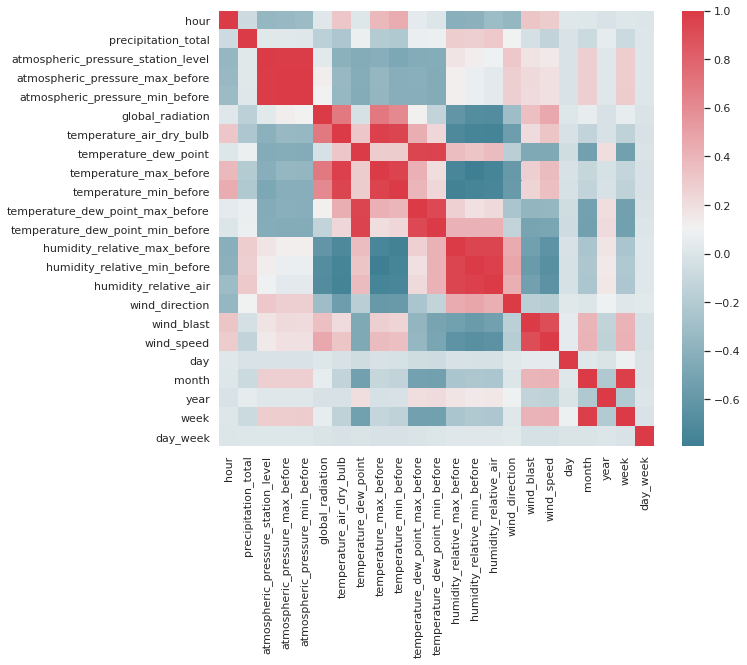

In [ ]:
# Plotamos um gráfico para ficar melhor de visualizar
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_selected.corr(), mask=np.zeros_like(df_selected.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Selecionando as colunas para o modelo
Após analisarmos a correlação com a nossa coluna alvo, vamos selecionar as colunas com maior correlação para o nosso dataset para o modelo. A faixa mínima escolhida foi de 50% de correlação (positiva ou negativa).

In [ ]:
target_cols = columns_corr.where(lambda x : np.logical_or(x > 0.50, x < -0.50)).dropna().index.tolist()
target_cols

['humidity_relative_air',
 'humidity_relative_min_before',
 'humidity_relative_max_before',
 'wind_direction',
 'global_radiation',
 'temperature_min_before',
 'temperature_max_before',
 'temperature_air_dry_bulb']

In [ ]:
# Filtramos o DataFrame para apenas as colunas que queremos usar
dataset = df_selected[target_cols]
# Mostramos as dimensões do DataFrame
print(dataset.shape)

(12018, 8)


# Explorando os dados selecionados
Iremos criar uma função chamada `print_eda` que irá nos mostrar alguns gráficos e valores que irão nos ajudar na etapa de exploração e identificação de _outliers_.

In [ ]:
# Layout padrão
default_layout = (8,2)
# Figsize padrão
default_figsize = (10,20)

def plot_density(df):
  """Plota o gráfico de densidade.
  """
  df.plot(kind="density",
          subplots=True,
          sharex=False,
          layout=default_layout,
          figsize=default_figsize)
  plt.tight_layout()
  plt.show()

def plot_box(df):
  """Plota o boxplot.
  """
  df.plot(kind="box",
          subplots=True,
          sharex=False,
          layout=default_layout,
          figsize=default_figsize)
  plt.tight_layout()
  plt.show()
  
def print_eda(df):
  """Mostra gráficos e valores relacionados a etapa de
  Exploratory Data Analysis (EDA)."""
  hr = '--------------------------------------------------------------'
  print("Density")
  plot_density(df)

  print(hr)
  print("Box")
  plot_box(df)

  print(hr)
  print("Shape")
  print(df.shape)

  print(hr)
  print("Correlação")
  print(df.corr()[target_col].sort_values())

  print(hr)
  print("Heatmap")
  sns.heatmap(df.corr())

Density


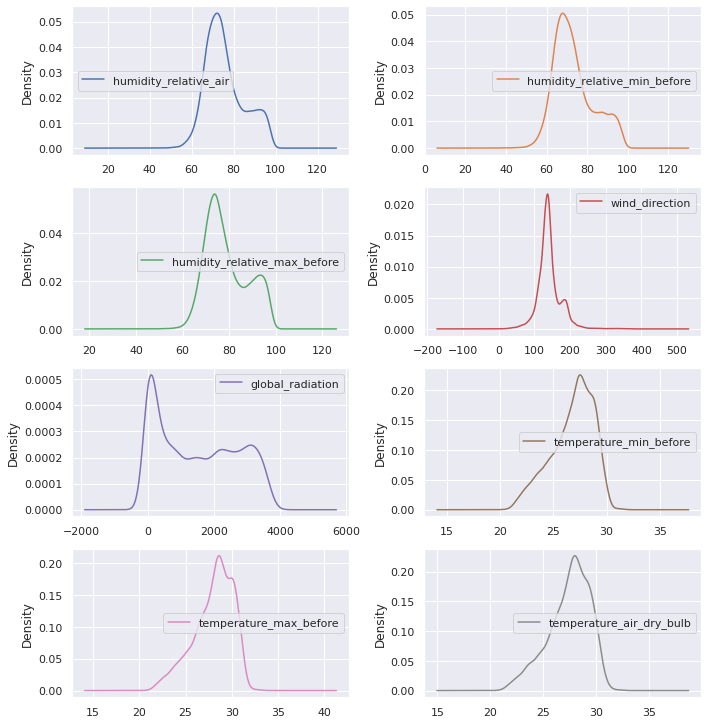

--------------------------------------------------------------
Box


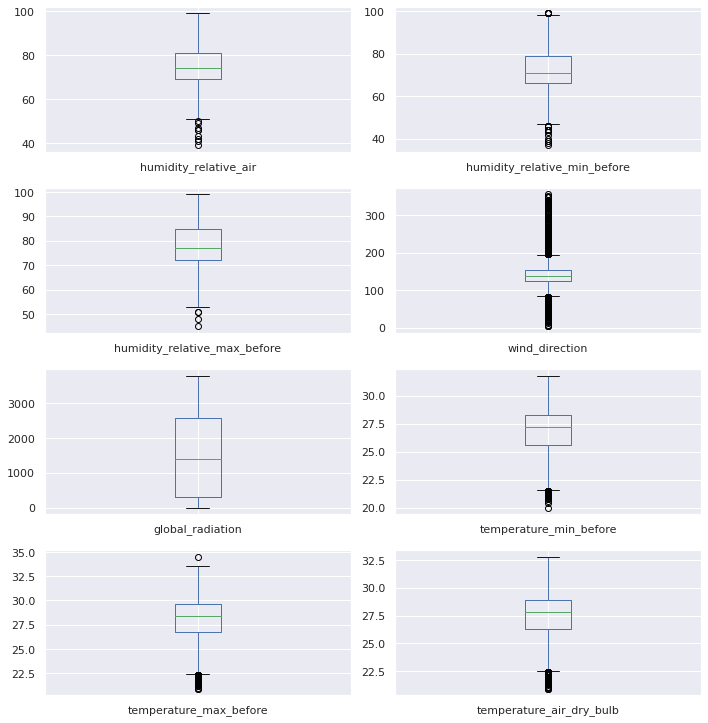

--------------------------------------------------------------
Shape
(12018, 8)
--------------------------------------------------------------
Correlação
humidity_relative_air          -0.759900
humidity_relative_min_before   -0.753720
humidity_relative_max_before   -0.709979
wind_direction                 -0.547639
global_radiation                0.698207
temperature_min_before          0.950094
temperature_max_before          0.971995
temperature_air_dry_bulb        1.000000
Name: temperature_air_dry_bulb, dtype: float64
--------------------------------------------------------------
Heatmap


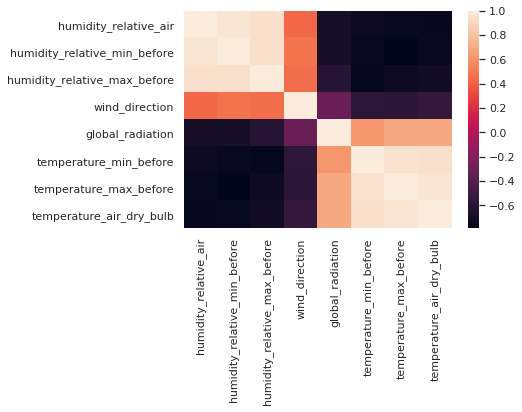

In [ ]:
# Mostrando os gráficos e valores dos dados que temos até agora
print_eda(dataset)

# Modelo inicial

In [ ]:
#rainfall_df = df[df['year'] >= 2019][['temperature_air_dry_bulb']]
#rainfall_df = dataset[['temperature_air_dry_bulb']]
rainfall_df = dataset
rainfall_df

,humidity_relative_air,humidity_relative_min_before,humidity_relative_max_before,wind_direction,global_radiation,temperature_min_before,temperature_max_before,temperature_air_dry_bulb
27033,84.0,80.0,84.0,194.0,34.5,25.8,26.9,25.8
27034,83.0,82.0,86.0,176.0,450.7,25.8,27.2,27.2
27035,72.0,72.0,83.0,157.0,1553.8,27.1,28.9,28.7
27036,71.0,69.0,76.0,140.0,1788.0,28.2,29.6,29.1
27037,67.0,65.0,76.0,137.0,2463.6,28.3,30.9,30.5
...,...,...,...,...,...,...,...,...
92921,67.0,62.0,67.0,136.0,2688.5,28.1,29.5,28.3
92922,71.0,65.0,71.0,132.0,1558.8,27.7,29.2,27.8
92923,73.0,66.0,74.0,139.0,1096.1,27.5,28.6,27.6
92924,76.0,73.0,76.0,150.0,314.8,26.8,27.9,27.0


In [ ]:
rainfall_df = tf.keras.utils.normalize(
    rainfall_df, axis=-1, order=2
)

In [ ]:
rainfall_df.head()

,humidity_relative_air,humidity_relative_min_before,humidity_relative_max_before,wind_direction,global_radiation,temperature_min_before,temperature_max_before,temperature_air_dry_bulb
27033,0.339015,0.322872,0.339015,0.782964,0.139238,0.104126,0.108566,0.104126
27034,0.163641,0.161669,0.169555,0.346997,0.888589,0.050867,0.053627,0.053627
27035,0.045919,0.045919,0.052934,0.100128,0.990950,0.017283,0.018431,0.018304
27036,0.039477,0.038365,0.042257,0.077842,0.994156,0.015680,0.016458,0.016180
27037,0.027116,0.026306,0.030758,0.055446,0.997052,0.011453,0.012506,0.012344


In [ ]:
train_split= 0.9
split_idx = int(len(rainfall_df) * 0.9)
training_set = rainfall_df[:split_idx].values
test_set = rainfall_df[split_idx:].values

In [ ]:
# 5-day prediction using 30 days data
x_train = []
y_train = []
n_future = 12 #Next 5 days rainfall forecast
n_past = 240 #Past 30 days
for i in range(0, len(training_set) - n_past - n_future + 1):
  x_train.append(training_set[i : i + n_past, 0])
  y_train.append(training_set[i + n_past : i + n_past + n_future, 0])

In [ ]:
x_train , y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1))

In [ ]:
EPOCHS = 500
BATCH_SIZE = 64
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=30, return_sequences=True,
                                 input_shape=(x_train.shape[1], 1))))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=32))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=n_future, activation='relu'))
regressor.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['acc']
)
regressor.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/500
166/166 [==============================] - 149s 898ms/step - loss: 0.0195 - acc: 0.0910
Epoch 2/500
166/166 [==============================] - 158s 952ms/step - loss: 0.0115 - acc: 0.3398
Epoch 3/500
166/166 [==============================] - 158s 951ms/step - loss: 0.0080 - acc: 0.4855
Epoch 4/500
166/166 [==============================] - 158s 953ms/step - loss: 0.0073 - acc: 0.5289
Epoch 5/500
166/166 [==============================] - 158s 953ms/step - loss: 0.0069 - acc: 0.5583
Epoch 6/500
166/166 [==============================] - 158s 954ms/step - loss: 0.0066 - acc: 0.5629
Epoch 7/500
166/166 [==============================] - 158s 950ms/step - loss: 0.0065 - acc: 0.5753
Epoch 8/500
166/166 [==============================] - 158s 953ms/step - loss: 0.0063 - acc: 0.5714
Epoch 9/500
166/166 [==============================] - 158s 951ms/step - loss: 0.0062 - acc: 0.5786
Epoch 10/500
166/166 [==============================] - 157s 947ms/step - loss: 0.0061 - acc: 0.5939

In [ ]:
x_test = test_set[: n_past, 0]
y_test = test_set[n_past: n_past + n_future, 0]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (1, x_test.shape[0], 1))
predicted_temperature = regressor.predict(x_test)
print('Predicted temperature {}'.format(predicted_temperature))
print('Real temperature {}'.format(y_test))

In [ ]:
regressor.summary()

# Referências
https://keras.io/examples/timeseries/timeseries_weather_forecasting/